# Assignment 3 copy
### By AnneLouise de Boer

The labelling typology for the dataset identifies for each comment a higher-level classification of whether that comment ‘has a place in
a healthy online conversation’, accompanied for
each comment by binary labels for whether it is:

(1) hostile,

(2) antagonistic, insulting, provocative or trolling (together, ‘antagonistic’),

(3) dismissive

(4) condescending or patronising (together, ‘condescending’)

(5) sarcastic

(6) an unfair generalisation.

For each label there is also an associated confidence score (between 0.5 and 1).

Trusted judgments column shows how many people have judged the comment. 

This is a multi-label classification problem.
Every label corresponds to a binary classification problem and each comment can belong to more than one label simultaneously. 
For example, in our case a comment may be hostile, sarcastic and dismissive at the same time.

We need to make a multi-labeled model capable of detecting different types of unhealthy like hostile, dismissive, antagonistic etc. We need to create a model which predicts a probability of each type of unhealthy for each comment.



The UCC contributes further high quality data on attributes like sarcasm, hostility, and condescension, adding to existing datasets on these and related attributes, and provides (to the best of our knowledge) the first dataset of this scale with labels for dismissiveness, unfair generalisations, antagonistic behavior, and overall assessments of whether those comments fall within 'healthy' conversation.




https://github.com/kesari007/Toxic-Comment-Classification/blob/master/Minor%202.ipynb

In [118]:
import pandas as pd

train_data_dir = "/Users/annelouisedeboer/PycharmProjects/unhealthy-conversations/corpus/train.csv"
test_data_dir = "/Users/annelouisedeboer/PycharmProjects/unhealthy-conversations/corpus/test.csv"
val_data_dir = "/Users/annelouisedeboer/Desktop/unhealthy-conversations-master/corpus/val.csv"
train = pd.read_csv(train_data_dir, index_col = "_unit_id")
test = pd.read_csv(test_data_dir, index_col = "_unit_id")
val = pd.read_csv(val_data_dir, index_col = "_unit_id")


frames = [train, val]

train = pd.concat(frames)


To increase the training dataset I will combine the validation and training dataset. Cros validation within the gridsearch, so to have more values to train on I combine the validation set and training set. 

In [119]:
print(train.columns)

Index(['_trusted_judgments', 'comment', 'antagonise', 'antagonise:confidence',
       'condescending', 'condescending:confidence', 'dismissive',
       'dismissive:confidence', 'generalisation', 'generalisation:confidence',
       'generalisation_unfair', 'generalisation_unfair:confidence', 'healthy',
       'healthy:confidence', 'hostile', 'hostile:confidence', 'sarcastic',
       'sarcastic:confidence'],
      dtype='object')


In [120]:
print(train.shape)

(39930, 18)


At first i reduced the size of the training data because it took my laptop a very long time to load. However, this could have been be due to the fact that it was loading the data from a web link and not from a file from my laptop directly. I later downloaded the files, so i could train on a bigger dataset. 
#train = train.sample(frac = 0.3)

In [121]:
print(train.dtypes)

_trusted_judgments                    int64
comment                              object
antagonise                            int64
antagonise:confidence               float64
condescending                         int64
condescending:confidence            float64
dismissive                            int64
dismissive:confidence               float64
generalisation                        int64
generalisation:confidence           float64
generalisation_unfair               float64
generalisation_unfair:confidence    float64
healthy                               int64
healthy:confidence                  float64
hostile                               int64
hostile:confidence                  float64
sarcastic                             int64
sarcastic:confidence                float64
dtype: object


In [122]:
print(train.isnull().values.any())

True


In [123]:
print(train.isna().any())

_trusted_judgments                  False
comment                              True
antagonise                          False
antagonise:confidence               False
condescending                       False
condescending:confidence            False
dismissive                          False
dismissive:confidence               False
generalisation                      False
generalisation:confidence           False
generalisation_unfair               False
generalisation_unfair:confidence    False
healthy                             False
healthy:confidence                  False
hostile                             False
hostile:confidence                  False
sarcastic                           False
sarcastic:confidence                False
dtype: bool


Colums that I will use do not contain NaN values.

In [124]:
print(train[(train["healthy"] == 1)])

            _trusted_judgments  \
_unit_id                         
2297540155                   5   
1812168131                   5   
1739466190                   3   
1739453667                   3   
1739459056                   3   
...                        ...   
1739458948                   3   
1739459188                   3   
1739448078                   3   
2327179148                   3   
1739469118                   3   

                                                      comment  antagonise  \
_unit_id                                                                    
2297540155  Personally I prefer the Flying Spaghetti Monst...           0   
1812168131  Your comparing a pipeline to a well? One that ...           0   
1739466190  Natives refuse to even consider that their cur...           0   
1739453667  Bush could very well win an election today in ...           0   
1739459056  Is a Trudeau endorsement OK? After all, he sup...           0   
...               

Looking at labels

In [125]:
label = train[["antagonise" , "condescending" , "dismissive" , "generalisation" , "generalisation_unfair" , "healthy" , "hostile" , "sarcastic"]]
labels = label.columns
confidence_labels = ['antagonise:confidence',
                     'condescending:confidence',
                     'dismissive:confidence',
                     'generalisation:confidence',
                     'generalisation_unfair:confidence',
                     'hostile:confidence',
                     'sarcastic:confidence']

# 1. Data Preparation
I will create new columns with confidence scores corresponding to the value 1 of each feature. In this way higher confidences weigh more and the two classes do not get mixed up (since confidence scores are > 0.5 initially).

In [126]:
newtrain = pd.DataFrame()
for feature in labels:
    for value in train[feature]:
        if value == 1:
            newtrain["P1" + feature] = train[feature+":confidence"]
            newtrain["P0" + feature] = 1 - train[feature+":confidence"]
        else:
            newtrain["P0" + feature] = train[feature+":confidence"]
            newtrain["P1" + feature] = 1 - train[feature+":confidence"]

In [127]:
x_train = newtrain.drop(['P0healthy','P1healthy'], axis = 1)
y_train = newtrain[["P0healthy","P1healthy"]].copy()

In [128]:
newtest = pd.DataFrame()
for feature in labels:
    for value in test[feature]:
        if value == 1:
            newtest["P1" + feature] = test[feature+":confidence"]
            newtest["P0" + feature] = 1 - test[feature+":confidence"]
        else:
            newtest["P0" + feature] = test[feature+":confidence"]
            newtest["P1" + feature] = 1 - test[feature+":confidence"]

In [129]:
x_test = newtest.drop(['P0healthy','P1healthy'], axis = 1)
y_test = newtest[["P0healthy","P1healthy"]].copy()

In [130]:
P1_labels = ["P1antagonise", "P1condescending", 
             "P1dismissive", "P1generalisation",
             "P1generalisation_unfair", "P1hostile",
             "P1sarcastic"]
P1_labels_and_P1healthy = ["P1healthy", "P1antagonise", "P1condescending", 
             "P1dismissive", "P1generalisation",
             "P1generalisation_unfair", "P1hostile",
             "P1sarcastic"]
print(x_train.head())

            P1antagonise  P0antagonise  P1condescending  P0condescending  \
_unit_id                                                                   
1739460326        0.4184        0.5816           0.4184           0.5816   
2297540155        0.0000        1.0000           0.0000           1.0000   
1812168131        0.0000        1.0000           0.1937           0.8063   
1739470334        0.2069        0.7931           0.4041           0.5959   
1739466190        0.0000        1.0000           0.0000           1.0000   

            P1dismissive  P0dismissive  P0generalisation  P1generalisation  \
_unit_id                                                                     
1739460326        0.4184        0.5816               1.0               0.0   
2297540155        0.0000        1.0000               1.0               0.0   
1812168131        0.0000        1.0000               1.0               0.0   
1739470334        0.4041        0.5959               1.0               0.0   

In [131]:
print(y_train)

            P0healthy  P1healthy
_unit_id                        
1739460326     0.4184     0.5816
2297540155     0.2019     0.7981
1812168131     0.3919     0.6081
1739470334     0.2083     0.7917
1739466190     0.0000     1.0000
...               ...        ...
1739458948     0.0000     1.0000
1739459188     0.0000     1.0000
1739448078     0.0000     1.0000
2327179148     0.0000     1.0000
1739469118     0.0000     1.0000

[39930 rows x 2 columns]


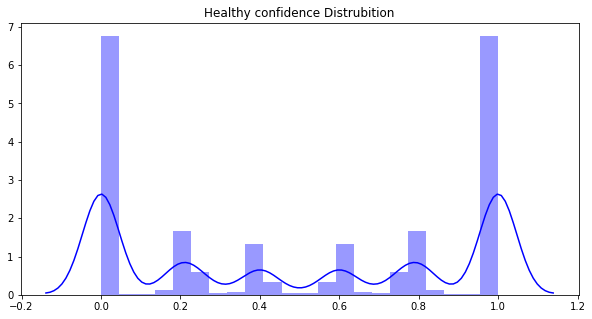

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
# Distribution of confidence score using histogram. 
plt.figure(figsize=(10,5))
plt.title('Distribution of "healthy" confidence score',size = 20)
sns.distplot(y_train,color='b');
plt.title("Healthy confidence Distrubition")
plt.show()

This analysis shows that most confidence scores are relatively high since values > 0.75 and < 0.25 show a higher confidence in a healthy comment and unhealthy comment respectively. 

# 1.2 Test, Train, and Sample Weights
I will train the binary classifier with the condifence values of each P1 label. (e.g. confidence that the comment is sarcastic.) Since it is a binary classification (healthy vs. unhealthy) the y_train and y_test will be the column containing binary classes 0 and 1. Since a classification of 1 with a confidence score 0.55 is not the same as a classification of 1 with a confidence score 0.99, I will use sample weights to give make the scores with more confidence weigh more.  

In [133]:
x_train = x_train[P1_labels]  #confidence values of the P1 labels
x_test = x_test[P1_labels]   #confidence values of the P1 labels
ytrain_sampleweight = train["healthy:confidence"].values #confidence label
ytest_sampleweight = test["healthy:confidence"].values #confidence label


In [134]:
#importing 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

In [135]:
#y_train and y_test for the classifiers
y_train = train["healthy"].values #class values 0 and 1
y_test = test["healthy"].values   #class values 0 and 1


In [136]:
print(y_train)
print(y_test)

[0 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


# 1.3 Correlation Matrix

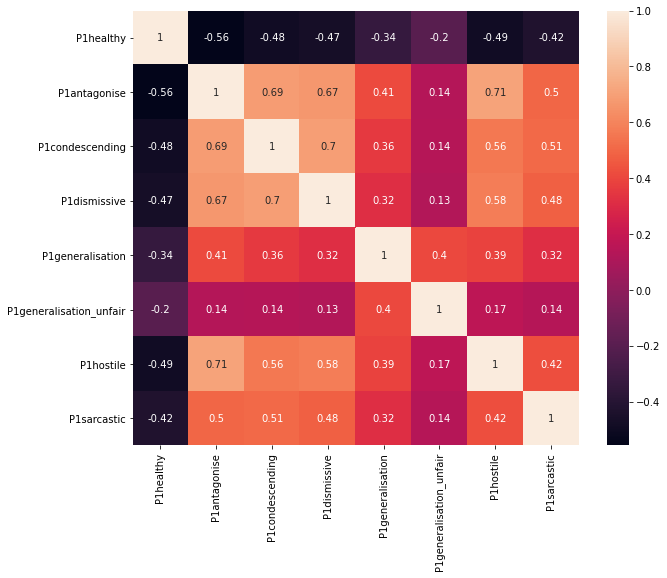

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

corrtrain = newtrain[P1_labels_and_P1healthy]
corr= corrtrain.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

Reading:
https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
Reading:
https://datascience.stackexchange.com/questions/19186/can-training-label-confidence-be-used-to-improve-prediction-accuracy



All features show a negative correlation with P1healthy. (healthy)

p0: probability that the label is 0.

p1: probability that the label is 1.

Thus they have a positive correlation with an unhealthy comment. 

# Hypothesis
### Cross entropy as a loss function
My prediction is that a model trained using a log loss function will give the best results as we are dealing with probabibilistic confidence scores. The penalty is logarithmic, offering a small score for small differences (0.1 or 0.2) and much bigger score for a large difference (e.g. 0.9 or 1.0). The loss function for logistic regression is the log loss.  Therefore I predict the logistic regression to give a good prediction as it gives a higher penalty when the probability is off. 

Reading:
https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/




## Creating Pipelines

In [138]:
#importing packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [139]:
#Decision tree pipeline
DecisionTreePipeline = Pipeline([ ('mypca',PCA(n_components=7)),
                     ('decisiontree_classifier',DecisionTreeClassifier())])

In [140]:
#RandomForest pipeline
RandomForestPipeline = Pipeline([ ('mypca',PCA(n_components=7)),
                     ('randomforest_classifier',RandomForestClassifier())])

In [141]:
#Logistic regression pipeline
LogisticregPipeline = Pipeline([ ('mypca',PCA(n_components=7)),
                     ('logisticreg_classifier',LogisticRegression())]) 

In [142]:
from sklearn.linear_model import SGDClassifier
#SGDClassifier pipeline
SGDclassifierpipeline = Pipeline([ ('mypca',PCA(n_components=7)),
                     ('sgd_classifier',SGDClassifier())]) 

In [143]:
from sklearn.neural_network import MLPClassifier

# Neural network classifier pipeline
MLPclassifierpipeline = Pipeline([ ('mypca',PCA(n_components=7)),
                     ('MLP_classifier',MLPClassifier())])



In [144]:
from sklearn.svm import LinearSVC
#Support Vector Machine classifier pipeline
SVMclassifierpipeline = Pipeline([ ('mypca',PCA(n_components=7)),
                     ('SVM_classifier',LinearSVC())])


In [505]:
## Defining the pipelines in a list
mypipeline = [LogisticregPipeline, DecisionTreePipeline, RandomForestPipeline, SGDclassifierpipeline, MLPclassifierpipeline, SVMclassifierpipeline]

In [146]:
#Defining variables for choosing best model
accuracy=0.0
classifier=0
pipeline=""

In [506]:
# Creating dictionary of pipelines and training models
PipelineDict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'Random Forest', 3: 'SGDclassifier', 4: 'Neural Network', 5: 'SVM'}

# Fit the pipelines
for mypipe in mypipeline:
    mypipe.fit(x_train, y_train)

In [507]:
#getting test accuracy for all classifiers
for i,model in enumerate(mypipeline):
    print("{} Test Accuracy: {}".format(PipelineDict[i],model.score(x_test,y_test)))

Logistic Regression Test Accuracy: 0.9265536723163842
Decision Tree Test Accuracy: 0.903728813559322
Random Forest Test Accuracy: 0.9290395480225989
SGDclassifier Test Accuracy: 0.927683615819209
Neural Network Test Accuracy: 0.9310734463276836
SVM Test Accuracy: 0.9290395480225989


In [149]:
#Choosing best model for the given data
for i,model in enumerate(mypipeline):
    if model.score(x_test,y_test)>accuracy:
        accuracy=model.score(x_test,y_test)
        pipeline=model
        classifier=i
print('Classifier with best accuracy:{}'.format(PipelineDict[classifier]))

Classifier with best accuracy:Neural Network


We are getting pretty good accuracy scores, but this is misleading. The data set is unbalanced because the number of healthy and unhealthy comments are unbalanced. If most of our comments are healthy (e.g. 90%) and we are classifying all as healthy, we could still get a good accuracy score. The problem is that we are looking for the minority class (unhealthy comments). I therefore need to use a different score that looks at the confusion matrix and takes precision and recall into consideration. 

We can see that this is a highly inbalanced dataset, where in most cases the comment is healthy. We are tyring to detect unhealthy comments, so we could end up with a bad model with high accuracy. I will therefore use the F1 score instead of accuracy to measure the performance of my model. The F1 macro score will be even better as it considers the minority class. (unhealthy comments we try to detect)

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

'Confusion Matrix: A breakdown of predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned).

Precision: A measure of a classifiers exactness.

Recall: A measure of a classifiers completeness

F1 Score (or F-score): A weighted average of precision and recall.

ROC Curves: Like precision and recall, accuracy is divided into sensitivity and specificity and models can be chosen based on the balance thresholds of these values."


In [150]:
len(y_train)

39930

In [151]:
len(y_train[y_train == 1])

36939

In [152]:
len(y_train[y_train ==0])

2991

In [153]:
len(y_test)

4425

In [154]:
len(y_test[y_test ==1])

4105

In [155]:
len(y_test[y_test ==0])

320

## 1. 4 Random Oversampling Imbalanced dataset
In addition, for imbalanced classification there are two main approaches to random resampling; they are oversampling and undersampling. Random Oversampling: Randomly duplicate examples in the minority class.

In [582]:
#Oversampling for each model 

import imblearn as imb
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score


# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy=0.5)
# fit and apply the transform
x_over, y_over = oversample.fit_resample(x_train, y_train)

# summarize class distribution
print(Counter(y_train))
print(Counter(y_over))

for i,mypipe in enumerate(mypipeline):
    mypipe.fit(x_over,y_over)
    y_pred = mypipe.predict(x_test)
    print(f"{PipelineDict[i]} f1 score (oversampling): {f1_score(y_test, y_pred)}")
    print(f"{PipelineDict[i]} f1 macro (oversampling): {f1_score(y_test, y_pred, average = 'macro')}")
    print(confusion_matrix(y_test, y_pred))

Counter({1: 36939, 0: 2991})
Counter({1: 36939, 0: 18469})
Logistic Regression f1 score (oversampling): 0.9279796048438496
Logistic Regression f1 macro (oversampling): 0.6828952750587407
[[ 220  100]
 [ 465 3640]]
Decision Tree f1 score (oversampling): 0.9518248175182481
Decision Tree f1 macro (oversampling): 0.6616266944734097
[[ 117  203]
 [ 193 3912]]
Random Forest f1 score (oversampling): 0.9533918984870668
Random Forest f1 macro (oversampling): 0.6846470195799249
[[ 136  184]
 [ 198 3907]]
SGDclassifier f1 score (oversampling): 0.9189328521716715
SGDclassifier f1 macro (oversampling): 0.671198781722866
[[ 231   89]
 [ 540 3565]]
Neural Network f1 score (oversampling): 0.9313074565883555
Neural Network f1 macro (oversampling): 0.70141011336294
[[ 240   80]
 [ 458 3647]]
SVM f1 score (oversampling): 0.9273329933707293
SVM f1 macro (oversampling): 0.6803662978782076
[[ 218  102]
 [ 468 3637]]


This added the amount of 50% of the majority class (of random duplicated of the minority class) to the minority class. 

## 1.5 Random undersampling for Imbalanced Dataset
Random Undersampling: Randomly delete examples in the majority class. As we are reducing the size of the dataset this could have a negative effect because there will be less data to train with. In undersampling we are losing data, so i predict that the model will work better using oversampling. 

My predication was correct, the f1 score is even worse with undersampling! As you can see below, oversampling does indeed score better than undersampling.

In [583]:
#Undersampling for each model 
from imblearn.under_sampling import NearMiss

#define undersampling strategy
nm = NearMiss()
#fit and apply the transform
x_under, y_under = nm.fit_sample(x_train, y_train)

# summarize class distribution
print(Counter(y_train))
print(Counter(y_under))

for i,mypipe in enumerate(mypipeline):
    mypipe.fit(x_under,y_under)
    y_pred = mypipe.predict(x_test)
    print(f"{PipelineDict[i]} f1 score (undersampling): {f1_score(y_test, y_pred)}")
    print(f"{PipelineDict[i]} f1 macro (undersampling): {f1_score(y_test, y_pred, average = 'macro')}")
    print(confusion_matrix(y_test, y_pred))

Counter({1: 36939, 0: 2991})
Counter({0: 2991, 1: 2991})
Logistic Regression f1 score (undersampling): 0.8249857712009107
Logistic Regression f1 macro (undersampling): 0.574951722043924
[[ 296   24]
 [1206 2899]]
Decision Tree f1 score (undersampling): 0.7690469076785181
Decision Tree f1 macro (undersampling): 0.525989131019222
[[ 305   15]
 [1531 2574]]
Random Forest f1 score (undersampling): 0.7686790197250449
Random Forest f1 macro (undersampling): 0.5256740789079348
[[ 305   15]
 [1533 2572]]
SGDclassifier f1 score (undersampling): 0.7856195668189185
SGDclassifier f1 macro (undersampling): 0.5401679995994738
[[ 304   16]
 [1439 2666]]
Neural Network f1 score (undersampling): 0.7694145758661888
Neural Network f1 macro (undersampling): 0.5263043167167527
[[ 305   15]
 [1529 2576]]
SVM f1 score (undersampling): 0.7848511641615089
SVM f1 macro (undersampling): 0.5387434115381188
[[ 302   18]
 [1442 2663]]


## 1.6 Combining Oversampling and Undersampling

In [584]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.5)
# fit and apply the transform
x, y = over.fit_resample(x_train, y_train)
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
x_cb, y_cb = under.fit_resample(x, y)

print(Counter(y_train))
print(Counter(y_cb))

for i,mypipe in enumerate(mypipeline):
    mypipe.fit(x_cb,y_cb)
    y_pred = mypipe.predict(x_test)
    print(f"{PipelineDict[i]} f1 score (combination): {f1_score(y_test, y_pred)}")
    print(f"{PipelineDict[i]} f1 macro (combination): {f1_score(y_test, y_pred, average = 'macro')}")
    print(confusion_matrix(y_test, y_pred))
    

Counter({1: 36939, 0: 2991})
Counter({1: 36938, 0: 18469})
Logistic Regression f1 score (combination): 0.9275325338096453
Logistic Regression f1 macro (combination): 0.683133855837629
[[ 222   98]
 [ 470 3635]]
Decision Tree f1 score (combination): 0.9481499513145083
Decision Tree f1 macro (combination): 0.6381128305468441
[[ 104  216]
 [ 210 3895]]
Random Forest f1 score (combination): 0.9537037037037037
Random Forest f1 macro (combination): 0.680901696088612
[[ 131  189]
 [ 191 3914]]
SGDclassifier f1 score (combination): 0.9141597510373443
SGDclassifier f1 macro (combination): 0.6662187155889709
[[ 238   82]
 [ 580 3525]]
Neural Network f1 score (combination): 0.9286171985133922
Neural Network f1 macro (combination): 0.6983105094763714
[[ 245   75]
 [ 482 3623]]
SVM f1 score (combination): 0.9269662921348315
SVM f1 macro (combination): 0.6825401205271407
[[ 223   97]
 [ 475 3630]]


 With these methods you show the wrong proportions of the two classes to the classifier during the training. I tried oversampling and undersampling and a combination of both, but this did not get significantly better results compared just using the training set. I hoped that the oversampling would increase the impact of minority class on cost function. Another approach to this would be using class weights to give class 0 (unhealthy) more importance. 

Source: https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

Source: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28

# 2. Evaluation of Models
## 2.1 F1 score for each classifier

In [588]:
#getting f1 scores for all classifiers
for i,model in enumerate(mypipeline):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print(f"{PipelineDict[i]} f1 score: {f1_score(y_test, y_pred)}")
    print(f"{PipelineDict[i]} f1 macro: {f1_score(y_test, y_pred, average = 'macro')}")
    print(confusion_matrix(y_test, y_pred))

Logistic Regression f1 score: 0.9612125551975177
Logistic Regression f1 macro: 0.6355956618875062
[[  73  247]
 [  78 4027]]
Decision Tree f1 score: 0.9487148251918627
Decision Tree f1 macro: 0.6459642768705023
[[ 110  210]
 [ 211 3894]]
Random Forest f1 score: 0.96045197740113
Random Forest f1 macro: 0.6704331450094162
[[ 101  219]
 [ 110 3995]]
SGDclassifier f1 score: 0.962485345838218
SGDclassifier f1 macro: 0.481242672919109
[[   0  320]
 [   0 4105]]
Neural Network f1 score: 0.9634218992017157
Neural Network f1 macro: 0.6458247351588448
[[  75  245]
 [  62 4043]]
SVM f1 score: 0.9630848812602869
SVM f1 macro: 0.5251470917929342
[[  15  305]
 [   9 4096]]


## 2.2  F1 score using sample weights
I want use the confidence score as a sample_weight for each binary value in the y_train. If people give a 0.51 score for healthy, that means something differnt than a 0.9 score for example. In this way you can make the output with higher confidence scores weigh more.

As you can see I used sample weights for fitting and scoring. The f1 score improved for each classifier. However, the F1 score can be misleading, from the confusion matrix we can see that eventhough the SGD gives a high F1 score, it is negatively biased. Since we try to detect unhealthy comments this is not useful, as it is the unhealthy comments (minority class) that we are looking for.

In [591]:
# import warnings filter
from warnings import simplefilter
from sklearn.metrics import f1_score
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

PipelineDict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'Random Forest', 3: 'SGDclassifier', 4: 'Neural Network', 5: 'SVM'}
#getting f1 scores for all classifiers
for i,model in enumerate(mypipeline):
    model.fit(x_over,y_over)     
    y_pred = model.predict(x_test)
    print(f"{PipelineDict[i]} f1 score: {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight)}")
    print(f"{PipelineDict[i]} f1 macro: {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight, average = 'macro')}")
    print(confusion_matrix(y_test, y_pred))
    

Logistic Regression f1 score: 0.942838421367013
Logistic Regression f1 macro: 0.6820422414879583
[[ 220  100]
 [ 465 3640]]
Decision Tree f1 score: 0.9638431651388342
Decision Tree f1 macro: 0.6743921364820071
[[ 120  200]
 [ 185 3920]]
Random Forest f1 score: 0.9639355661361972
Random Forest f1 macro: 0.6887533340712815
[[ 137  183]
 [ 200 3905]]
SGDclassifier f1 score: 0.9399221854965334
SGDclassifier f1 macro: 0.6762186480976564
[[ 222   98]
 [ 492 3613]]
Neural Network f1 score: 0.9386024980210929
Neural Network f1 macro: 0.6882700115214213
[[ 248   72]
 [ 529 3576]]
SVM f1 score: 0.9423948956622467
SVM f1 macro: 0.6799751247094495
[[ 218  102]
 [ 468 3637]]


In [595]:
# I will plot the ROC curve of the three best models below
#The models are trained on oversampled data
mlpmodel = MLPclassifierpipeline.fit(x_over,y_over)
svmmodel = SVMclassifierpipeline.fit(x_train,y_train)
rfmodel = RandomForestPipeline.fit(x_train,y_train)

# 3. Hyperparameter tuning
I will focus on the top 3 best scoring models, namely the the Decision Tree, Random Forest Classifier,and Logistic regression.  
## 3.1 Random Forest Classifier
https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6Hyperparameter 

As the source says, hyperparameter tuning can be useful. But for the random forest classifier, it might not be necessary as it is already good at classification. Using a gridsearch can take a lot of time and not show significant changes in  results. This is true here as the best model from the Gridsearch actually performs worse than the model in 2.1. I suspect that this is due to the fact that in 2.1 I used PCA (in the pipeline), which I could not do here.

I used F1 micro for scoring in the gridsearch because of the class inbalance.  As the training data is skewed towards the healthy class (there are more comments that are healthy) and micro shows how the classifier is working in the case of class inbalance.

In [589]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', ],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rnd_clf, param_grid=param_grid, cv= 5, verbose = 1, scoring='f1_macro')
CV_rfc.fit(x_train, y_train,sample_weight= ytrain_sampleweight)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.3min finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy',
                                              max_features='sqrt',
                                              n_estimators=200),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 200]},
             scoring='f1_macro', verbose=1)

In [590]:
CV_rfc.best_params_

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 100}

In [336]:
best_forest = RandomForestClassifier(criterion = 'entropy', max_features ='sqrt', n_estimators = 100)

In [603]:
# Confusion matrix for Gridsearch with optimized hyperparameters
grid_forest = best_forest.fit(x_train,y_train, sample_weight= ytrain_sampleweight)
y_pred = best_forest.predict(x_test)
print(f"f1 score with sample weights: {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight)}")
print(f"f1 macro with sample weights: {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight, average = 'macro')}")
confusion_matrix(y_test, y_pred)

f1 score with sample weights: 0.9707778109448993
f1 macro with sample weights: 0.6715456697866516


array([[  93,  227],
       [  93, 4012]])

## 3.2 Logistic Regression

In [568]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


## Logictic regression
import numpy as np

param_grid = {
    'penalty':['l1', 'l2'],
    'solver' : ['liblinear','lbfgs', 'saga'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
LG_grid = GridSearchCV(estimator =LogisticRegression(), param_grid = param_grid, n_jobs=1, scoring='f1_macro')
LG_grid.fit(x_train,y_train,sample_weight= ytrain_sampleweight)

/Users/annelouisedeboer/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/annelouisedeboer/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/annelouisedeboer/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/annelouisedeboer/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The sco

GridSearchCV(estimator=LogisticRegression(), n_jobs=1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             scoring='f1_macro')

In [574]:
LG_grid.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

In [610]:
best_log = LogisticRegression(C = 1, penalty = 'l2', solver = 'lbfgs' )

In [577]:
# Confusion matrix for Gridsearch optimized hyperparameters
from sklearn.metrics import confusion_matrix
best_log.fit(x_train,y_train,sample_weight= ytrain_sampleweight)
y_pred = best_log.predict(x_test)
print(f"f1 score : {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight)}")
print(f"f1 macro with sample weights: {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight, average = 'macro')}")
confusion_matrix(y_test, y_pred)

f1 score : 0.9311798990427479
f1 macro with sample weights: 0.6673131148030618


array([[ 242,   78],
       [ 583, 3522]])

The f1 score (macro) increased compared to the logistic regression before using gridsearch. 
At first I used the loss function F1_micro. This gridsearch created a very biased classifier. Later I realized that I should be using F1_macro, to look at the minority class. 

I will fit this tuned model to the resampled data. As you can see below, when the moddel is fitted to resampled data it has a better F1_macro score. We can also see that this model (3.2.1) is better than the pipeline used before (3.2.2). The model in 3.2.3 is trained and fitted using sample weights.



## 3.2.1 Logistic regression with resampled data


In [611]:
# Confusion matrix for Gridsearch optimized hyperparameters (resample data check)
#combination of oversampling and undersampling
from sklearn.metrics import confusion_matrix
log_resample = best_log.fit(x_cb,y_cb)
y_pred = best_log.predict(x_test)
print(f"f1 score with resampling (combination under/over sampling): {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight)}")
print(f"f1 macro with sample weights: {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight, average = 'macro')}")
print(confusion_matrix(y_test, y_pred))


f1 score with resampling (combination under/over sampling): 0.9424608006209825
f1 macro with sample weights: 0.6822613470379696
[[ 222   98]
 [ 470 3635]]


## 3.2.2 Logistic regression with PCA

In [614]:
logpipe = LogisticregPipeline.fit(x_train,y_train)
y_pred = logpipe.predict(x_test)
print(f"f1 macro with sample weights: {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight, average = 'macro')}")

f1 macro with sample weights: 0.640179610613905



## 3.2.3 Logistic regression trained with weighted samples

In [615]:
weightedlog = LogisticRegression().fit(x_train,y_train,sample_weight= ytrain_sampleweight)
y_pred = weighinglog.predict(x_test)
print(f"f1 macro with sample weights: {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight, average = 'macro')}")


f1 macro with sample weights: 0.6673131148030618


# 4. Ensemble Method
The random forest classifier is already an example of a bagging algorithm. 

## 4.1 Boosting

- For boosting, base estimators are built sequentially to produce a more powerful ensemble. 
- For boosting you create a bag and compare the training predicted score with training actual score. You will get some false positive and some false negative, these are saved and added to another bag picked randomly. You train with the ones that you predicted wrong. Pass the false negatives and false positives to the next bag and train again. In this way you are reducing your error. In this way misclassified data increases its weights to emphasise the most difficult cases. 

Boosting is making some of the models more biased toward the negative values.

In [624]:
#Boosting - Ada Boost
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier


## Defining the pipelines in a list
boostmodels = [RandomForestClassifier(), DecisionTreeClassifier(), SGDClassifier(), LinearSVC(),] 
boostmodelDict = {0: 'RF', 1: 'Decisiontree',  2: 'SGDclassifier', 3: 'SVM'}  

for i,mymodel in enumerate(boostmodels):  
    #defining boosting classifier
    adb = AdaBoostClassifier(mymodel, algorithm='SAMME')
    adb.fit(x_train,y_train)
    y_pred = adb.predict(x_test)
    print(f"f1 score with sample weights: {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight, average = 'macro')}")
    print( f'{boostmodelDict[i]} confusion matrix:{confusion_matrix(y_test, y_pred)}') 

f1 score with sample weights: 0.6857848978786656
RF confusion matrix:[[  97  223]
 [  77 4028]]
f1 score with sample weights: 0.676112505656302
Decisiontree confusion matrix:[[ 118  202]
 [ 169 3936]]
f1 score with sample weights: 0.4857122876619619
SGDclassifier confusion matrix:[[   0  320]
 [   0 4105]]
f1 score with sample weights: 0.4857122876619619
SVM confusion matrix:[[   0  320]
 [   0 4105]]


In [449]:
#I will plot the ROC curves for the boosted decision tree and random forest classifier below
adb = AdaBoostClassifier(RandomForestClassifier(), algorithm='SAMME')
boostedFR = adb.fit(x_train,y_train)

adb = AdaBoostClassifier(DecisionTreeClassifier(), algorithm='SAMME')
boostedDT = adb.fit(x_train,y_train)


https://scikit-learn.org/stable/modules/ensemble.html

## 4.2 Hard Voting
I first tried hard voting, then I will see how it compares to soft voting. It could be better than the strongest individual classifier. For voting I will use the models that scored best with the sample weights. As you can see below, the Voting Classifier detects more true positives than the RandomForest classifier. 

In [619]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

models = [('RF', RandomForestClassifier()), ('Decisiontree', DecisionTreeClassifier()), ('SVM',LinearSVC())]

#soft voting
voting_clf = VotingClassifier(
estimators= models,
voting="hard",
)
hardvoteclf = voting_clf.fit(x_train, y_train, sample_weight= ytrain_sampleweight)
gmodels =  [RandomForestClassifier(), DecisionTreeClassifier(), LinearSVC(), voting_clf]
for clf in gmodels:
    clf.fit(x_train, y_train, sample_weight= ytrain_sampleweight)
    y_pred = clf.predict(x_test)
    print( f' {clf.__class__.__name__} confusion matrix:{confusion_matrix(y_test, y_pred)}')
    print(f"f1 macro {clf.__class__.__name__}: {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight,average = 'macro')}")

 RandomForestClassifier confusion matrix:[[  89  231]
 [  89 4016]]
f1 macro RandomForestClassifier: 0.6674468971053829
 DecisionTreeClassifier confusion matrix:[[ 110  210]
 [ 180 3925]]
f1 macro DecisionTreeClassifier: 0.662802117804536
 LinearSVC confusion matrix:[[ 272   48]
 [ 901 3204]]
f1 macro LinearSVC: 0.6163025649925539
 VotingClassifier confusion matrix:[[ 135  185]
 [ 188 3917]]
f1 macro VotingClassifier: 0.6952472111363239


## 4.3 Soft Voting

In [468]:
#as the LinearSVC could not return a probability for soft voting, I tried changing the model. 
linclf= SVC(kernel='linear',probability=True)

In [621]:
#soft voting

models = [('RF', RandomForestClassifier()), ('Decisiontree', DecisionTreeClassifier()), ('SVM',linclf)] 

soft_voting_clf = VotingClassifier(
    estimators= models,
    voting="soft")

softvoteclf = soft_voting_clf.fit(x_train, y_train, sample_weight= ytrain_sampleweight)

gmodels =  [RandomForestClassifier(), DecisionTreeClassifier(), LinearSVC(), soft_voting_clf]
for clf in gmodels:
    clf.fit(x_train, y_train, sample_weight= ytrain_sampleweight)
    y_pred = clf.predict(x_test)
    print( f' {clf.__class__.__name__} confusion matrix:{confusion_matrix(y_test, y_pred)}')
    print(f"f1 macro {clf.__class__.__name__}: {f1_score(y_test, y_pred,sample_weight= ytest_sampleweight,average = 'macro')}")


 RandomForestClassifier confusion matrix:[[  90  230]
 [  90 4015]]
f1 macro RandomForestClassifier: 0.6690567094559048
 DecisionTreeClassifier confusion matrix:[[ 110  210]
 [ 180 3925]]
f1 macro DecisionTreeClassifier: 0.6613786160399301
 LinearSVC confusion matrix:[[ 272   48]
 [ 901 3204]]
f1 macro LinearSVC: 0.6163025649925539
 VotingClassifier confusion matrix:[[  72  248]
 [  77 4028]]
f1 macro VotingClassifier: 0.6420139020207096


# Model Comparison

## AUC and ROC
Plot the ROC of every model and check which one has the highest AUC. AUC / ROC will do this automatically using a threshold. Whichever has most points closer to 1 is the best one. 
 
for this example .. and .. are more stable than the other methods.

Each value for the threshold gives a point (false positive, true positive). The ROC curve describes the ensemble of points creted when T varies from 1 to 0. A good model will have a curve that increases quickly from 0 to 1 (this means that little precision has to be sacrificed to get a high recall).

https://quantdev.ssri.psu.edu/sites/qdev/files/09_EnsembleMethods_2017_1127.html

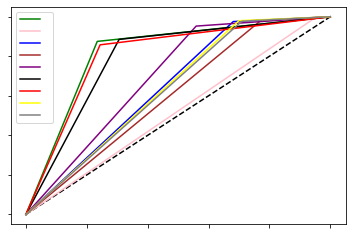

In [613]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
#1. PCA and Neural Network
y_pred = mlpmodel.predict(x_test)
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred)
#2. PCA and LinearSVC
y_pred = svmmodel.predict(x_test)
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred)
#3. PCA and Random forest classifier
y_pred = rfmodel.predict(x_test)
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred)
#4. PCA and Logistic regression
y_pred = logpipe.predict(x_test)
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred)
#5. Hard Voting
y_pred = hardvoteclf.predict(x_test)
fpr5 , tpr5, thresholds5 = roc_curve(y_test, y_pred)
#6. Logistic regression trained on resampled data
y_pred = log_resample.predict(x_test)
fpr6 , tpr6, thresholds6 = roc_curve(y_test, y_pred)
#7. Logistic regression with weighted samples
y_pred = weightedlog.predict(x_test)
fpr7 , tpr7, thresholds7 = roc_curve(y_test, y_pred)
#8. Boosted Random Forest Classifier
y_pred = boostedFR.predict(x_test)
fpr8 , tpr8, thresholds8 = roc_curve(y_test, y_pred)
#9. Random Forest classifier Gridsearch
y_pred = grid_forest.predict(x_test)
fpr9 , tpr9, thresholds = roc_curve(y_test, y_pred)



plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, color = 'green', label= "mlp: Neural network")
plt.plot(fpr2, tpr2, color = 'pink', label= "svm: LinearSVC")
plt.plot(fpr3, tpr3, color = 'blue', label= "rf: Random Forest with PCA")
plt.plot(fpr4, tpr4, color = 'brown', label= "log: Logistic Regression with PCA")
plt.plot(fpr5, tpr5, color = 'purple', label= "hardvoteclf")
plt.plot(fpr6, tpr6, color = 'black', label= "logresample")
plt.plot(fpr7, tpr7, color = 'red', label= "weightedlog")
plt.plot(fpr8, tpr8, color = 'yellow', label= "boosted Random Forest Classifier")
plt.plot(fpr9, tpr9, color = 'grey', label= "Gridsearch Random Forest Classifier")

plt.legend(loc='best')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC curves for chosen best models')
plt.show()

## Precision-Recall curve
Since our data is unbalanced I thought it would be useful to look at precision and recall (for the same reason I was using f1_score instead of accuracy)In the case of unbalanced data the ROC curves present an optimistic picture of the model.
"The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate."
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

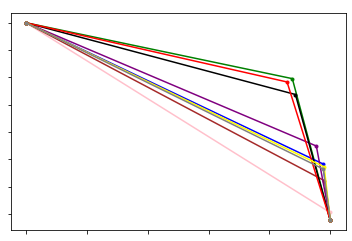

In [629]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
#1. PCA and Neural Network
good_probs = mlpmodel.predict(x_test)
precision1, recall1, _ = precision_recall_curve(y_test, good_probs)
#2. PCA and LinearSVC
good_probs = svmmodel.predict(x_test)
precision2, recall2, _ = precision_recall_curve(y_test, good_probs)
#3. PCA and Random forest classifier
good_probs = rfmodel.predict(x_test)
precision3, recall3, _ = precision_recall_curve(y_test, good_probs)
#4. PCA and Logistic regression
good_probs = logpipe.predict(x_test)
precision4, recall4, _ = precision_recall_curve(y_test, good_probs)
#5. Hard Voting
good_probs = hardvoteclf.predict(x_test)
precision5, recall5, _ = precision_recall_curve(y_test, good_probs)
#6. Logistic regression trained on resampled data
good_probs = log_resample.predict(x_test)
precision6, recall6, _ = precision_recall_curve(y_test, good_probs)
#7. Logistic regression with weighted samples
good_probs = weightedlog.predict(x_test)
precision7, recall7, _ = precision_recall_curve(y_test, good_probs)
#8. Boosted Random Forest Classifier
good_probs = boostedFR.predict(x_test)
precision8, recall8, _ = precision_recall_curve(y_test, good_probs)
#9. Random Forest classifier Gridsearch
good_probs = grid_forest.predict(x_test)
precision9, recall9, _ = precision_recall_curve(y_test, good_probs)


plt.figure()
plt.plot(recall1, precision1, marker=".",color = 'green', label= "mlp: Neural network")
plt.plot(recall2, precision2, marker=".",color = 'pink', label = "svm: LinearSVC")
plt.plot(recall3, precision3, marker=".",color = 'blue', label= "rf: Random Forest with PCA")
plt.plot(recall4, precision4, marker=".",color = 'brown', label= "log: Logistic Regression with PCA")
plt.plot(recall5, precision5, marker=".",color = 'purple', label= "hardvoteclf")
plt.plot(recall6, precision6, marker=".",color = 'black', label= "logresample")
plt.plot(recall7, precision7, marker=".",color = 'red', label= "weightedlog")
plt.plot(recall8, precision8, marker=".",color = 'yellow', label= "boosted Random Forest Classifier")
plt.plot(recall9, precision9, marker=".",color = 'grey', label= "Gridsearch Random Forest Classifier")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.show()
plt.close("all")

# Conclusion

Eventhough this report might be long and disorganized, I did not want to remove my attempt at making better models. I wanted to include all my attempts in this report to show what I practised. I have included the following techniques in this report:
- Pipelines, with PCA and the model
- Oversampling, Undersampling, and a combination of both
- fitting the models using sample weights
- gridsearch, using f1_macro as a loss function
- boosting
- hardvoting
- softvoting


From the precision - recall curve I conclude that the Neural Network and logistic regression fitted on weighted samples (3.2.3) are the best classifiers. 

When I compare the three logictic regression models I created 3.2 it is clear that the logistic regression trained on oversampled data (3.2.1) performs much better than the logistic regression pipeline (with PCA). 
However, by 3.2.3 the logistic regression fitted using weighted samples performs best. 

## Questions
- why are the labels not showing in my ROC plot?
- Could it be the case that the boosting is making my model baised as it predicts using all predictors and weight result by accuracies. Since this is an inbalanced dataset, boosting according to accuracy might not be the best method?